In [1]:
import os
import shutil
import zipfile
import tensorflow as tf

In [2]:
# Function to rename files in a folder
def rename_files(folder_path, label):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter to include only .gif files
    gif_files = [f for f in files if f.endswith('.gif')]

    # Rename each file
    for index, filename in enumerate(gif_files):
        # Construct new file name
        new_name = f"{label}_{index + 1}.gif"

        # Get full path for the old and new file names
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_name)

        # Rename the file
        os.rename(old_file, new_file)
    print(f"Renamed files in {folder_path} to {label}_#.gif")

In [3]:
# Extract the zip file
zip_file_path = '/dgxa_home/se20ucse083/gif_data.zip'
extracted_folder = 'gif_data_extracted.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

In [4]:
# Paths to the extracted folders
sad_folder = os.path.join(extracted_folder, 'Sad_2')
happy_folder = os.path.join(extracted_folder, 'Happy_3')
sarcasm_folder = os.path.join(extracted_folder, 'Sarcasm_4')

In [5]:
# Rename the files in each folder
rename_files(sad_folder, 'sad')
rename_files(happy_folder, 'happy')
rename_files(sarcasm_folder, 'sarcasm')

Renamed files in gif_data_extracted.zip/Sad_2 to sad_#.gif
Renamed files in gif_data_extracted.zip/Happy_3 to happy_#.gif
Renamed files in gif_data_extracted.zip/Sarcasm_4 to sarcasm_#.gif


In [6]:
# Load and preprocess data without data augmentation
def load_data(data_dir, image_size, batch_size, validation_split=0.35):
    # Load and preprocess training data with validation split
    train_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='training',
        seed=123
    )

    # Load and preprocess validation data with validation split
    val_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='validation',
        seed=123
    )

    return train_data, val_data

In [7]:
# Set parameters (gloabl for all algo)
data_dir = '/dgxa_home/se20ucse083/gif_data_extracted.zip'
image_size = (224, 224)
batch_size = 32
num_classes = 3

In [8]:
# Calculate class weights to handle class imbalance
def calculate_class_weights(data_dir):
    # Count the number of samples in each class
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        class_counts[class_name] = len(os.listdir(class_path))


    # Calculate class weights
    total_samples = sum(class_counts.values())
    class_weights = {}
    for class_name, count in class_counts.items():
        class_weights[class_name] = total_samples / (len(class_counts) * count)

    return class_weights

In [9]:
# Load the data (global for all algo)
train_data, val_data = load_data(data_dir, image_size, batch_size)

Found 5448 files belonging to 3 classes.
Using 3542 files for training.
Found 5448 files belonging to 3 classes.
Using 1906 files for validation.


In [10]:
calculate_class_weights(data_dir)

{'Happy_3': 0.9293756397134084, 'Sad_2': 4.54, 'Sarcasm_4': 0.5869424692954105}

Resnet +CNN

In [21]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve,auc

In [22]:
# Load pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Add custom CNN layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

In [13]:
# Model to be trained
model_resnet_cnn = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [15]:
# Compile the model
model_resnet_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Train the model using dgx------------------------------------------------
history = model_resnet_cnn.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
111/111 [==============================] - 228s 2s/step - loss: 1.1144 - accuracy: 0.4972 - val_loss: 0.9001 - val_accuracy: 0.5609
Epoch 2/10
111/111 [==============================] - 224s 2s/step - loss: 0.9161 - accuracy: 0.5361 - val_loss: 0.8981 - val_accuracy: 0.5540
Epoch 3/10
111/111 [==============================] - 225s 2s/step - loss: 0.8922 - accuracy: 0.5607 - val_loss: 0.8700 - val_accuracy: 0.5598
Epoch 4/10
111/111 [==============================] - 222s 2s/step - loss: 0.8719 - accuracy: 0.5663 - val_loss: 0.8630 - val_accuracy: 0.5630
Epoch 5/10
111/111 [==============================] - 220s 2s/step - loss: 0.8563 - accuracy: 0.5697 - val_loss: 0.8597 - val_accuracy: 0.5598
Epoch 6/10
111/111 [==============================] - 209s 2s/step - loss: 0.8359 - accuracy: 0.5748 - val_loss: 0.8531 - val_accuracy: 0.5598
Epoch 7/10
111/111 [==============================] - 209s 2s/step - loss: 0.8497 - accuracy: 0.5768 - val_loss: 0.8624 - val_accuracy: 0.5640

In [17]:
# Evaluate the model on the training data
print("Evaluating the model...")
train_loss, train_accuracy = model_resnet_cnn.evaluate(train_data, verbose=0)
print(f"Training loss for resnet+cnn: {train_loss}")
print(f"Training accuracy for resnet+cnn: {train_accuracy}")

# Evaluate the model on the validation data
print("Evaluating the model...")
Val_loss, val_acc = model_resnet_cnn.evaluate(val_data, verbose=0)
print(f"val loss for resnet+cnn: {Val_loss}")
print(f"val accuracy for resnet+cnn: {val_acc}")

Evaluating the model...
Training loss for resnet+cnn: 0.809411346912384
Training accuracy for resnet+cnn: 0.5931677222251892
Evaluating the model...
val loss for resnet+cnn: 0.8564152121543884
val accuracy for resnet+cnn: 0.569779634475708


In [18]:
y_pred = model_resnet_cnn.predict(val_data)
y_true = np.concatenate([y for x, y in val_data], axis=0)

60/60 [==============================] - 74s 1s/step


In [23]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(fpr[i])
    print(tpr[i])
print(roc_auc)

[0.         0.001638   0.001638   0.002457   0.002457   0.00573301
 0.00573301 0.00573301 0.00573301 0.00655201 0.00655201 0.00737101
 0.00737101 0.00819001 0.00819001 0.01310401 0.01310401 0.01474201
 0.01556102 0.01801802 0.02129402 0.02211302 0.02375102 0.02538903
 0.02538903 0.03030303 0.03030303 0.03112203 0.03276003 0.03603604
 0.03603604 0.03685504 0.04013104 0.04095004 0.04258804 0.04340704
 0.04668305 0.04668305 0.04914005 0.04914005 0.04995905 0.04995905
 0.05159705 0.05323505 0.05405405 0.05487305 0.05733006 0.05733006
 0.05896806 0.05896806 0.06224406 0.06224406 0.06552007 0.06633907
 0.06797707 0.06797707 0.06879607 0.06879607 0.07043407 0.07043407
 0.07043407 0.07289107 0.07289107 0.07862408 0.07944308 0.08353808
 0.08353808 0.08435708 0.08435708 0.08517609 0.08599509 0.08845209
 0.08845209 0.08927109 0.08927109 0.09009009 0.09336609 0.09336609
 0.09418509 0.09418509 0.0958231  0.0966421  0.0974611  0.0974611
 0.0982801  0.0982801  0.0990991  0.0990991  0.0999181  0.09991

In [25]:
!pip install matplotlib
import matplotlib.pyplot as plt

Keyring is skipped due to an exception: 'keyring.backends'


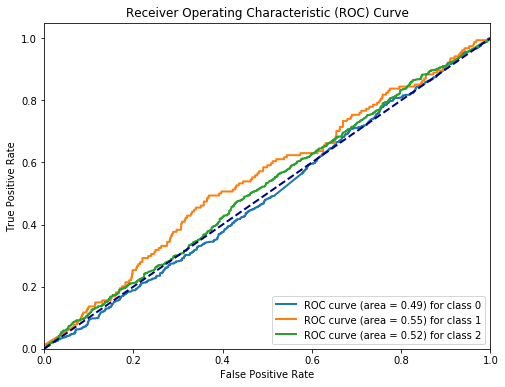

In [26]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()